In this notebook we are normalizing the features of every patient to be w.r.t. their stable periods

In [2]:
import numpy as np
import pandas as pd
## pls excuse
import os, sys
up1 = os.path.abspath('..'); sys.path.insert(0, up1)
## pls excuse
import data.utilities as du
def collectSinusRhythmBaselinesForPatients(src: pd.DataFrame) -> dict:
    """

    Args:
        src (pd.DataFrame): Expected to contain ['patient_id', 'time', 'rhythm'], and all feature columns found in `afib_detection/data/config.yml`
    """
    result = {} #dictionary keyed on patient_id pointing to feature->(mean, iqr) dictionary
    features = du.getDataConfig().features_nk
    for patient_id, OGid_group in src.groupby('patient_id'):
        #for each patient find points in sinus
        id_group = OGid_group[OGid_group['rhythm'] == 'sinus']
        if (len(id_group) == 0):
            id_group = OGid_group[OGid_group['rhythm'] == 'unknown']
            # display(OGid_group)
            # display(rhythmDF[rhythmDF['patient_id'] == patient_id])
            # print(1/0)
            # continue
        if (len(id_group) == 0):
            print(f'REALLY skipping {patient_id}')
            continue
        result[patient_id] = dict()
        for feature in features:
            result[patient_id][feature] = dict()
            result[patient_id][feature]['mean'] = np.mean(id_group[feature])
            result[patient_id][feature]['median'] = np.median(id_group[feature])
            q_25, q_75 = np.percentile(id_group[feature].to_numpy(), [25, 75])
            result[patient_id][feature]['quartile_75'] = q_75
            result[patient_id][feature]['quartile_25'] = q_25
    return result

# dataDF = pd.read_csv('filtered_unchecked_featurized.csv', parse_dates=['time'], dtype={'patient_id': str})
dataDF = pd.read_csv('../data/assets/featurized_all_5min.csv', parse_dates=['time'], dtype={'patient_id': str})
display(dataDF)
rhythmDF = pd.read_csv('stitched_annotations.csv', parse_dates=['start', 'stop'], dtype={'id': str})
rhythmDF['patient_id'] = rhythmDF['id']; rhythmDF.drop(columns=['id'], inplace=True)
display(rhythmDF)
## wish to add 'rhythm' column to dataDF populated with whether the point in time is afib or sinus
def findRhythm(row):
    patientRhythms = rhythmDF[rhythmDF['patient_id'] == row['patient_id']]
    patientRhythms.reset_index()
    nearestAnnotationIdx = np.searchsorted(patientRhythms['stop'], row['time'])
    nearestAnnotationIdx = max(nearestAnnotationIdx, 0)
    if (nearestAnnotationIdx == len(patientRhythms)):
        return 'not_sinus'
    else:
        nearestAnnotation = patientRhythms.iloc[nearestAnnotationIdx, :]
        # if (row['patient_id'] == '03'):
        #     print(nearestAnnotation)
        #     print(row)
        #     print(1/0)
        if ((nearestAnnotation['start'] <= row['time']) and (row['time'] <= nearestAnnotation['stop'])):
            return nearestAnnotation['rhythm']
    return 'unknown'
dataDF['rhythm'] = dataDF.apply(findRhythm, axis=1)
sinusRhythmBaselines = collectSinusRhythmBaselinesForPatients(dataDF)
from IPython.display import display
import pickle
with open('sinusRhythmBaselines.pkl', 'wb') as writefile:
    pickle.dump(sinusRhythmBaselines, writefile)

,patient_id,time,basetime,b2b_var,b2b_iqr,b2b_range,b2b_std,ecg_rate_mean,hrv_rmssd,hrv_sdnn,...,hrv_hf,hrv_lfhf,hrv_sd1,hrv_sd2,hrv_sd1sd2,hrv_pnn20,hrv_pnn50,hrv_sampen,hrv_shanen,hrv_apen
0,00,2003-01-31 09:35:00,2003-01-31 09:30:00,0.069295,3.750916,123.220947,8.257661,75.807506,5142.511932,5156.175321,...,0.000039,4.846691,3636.261725,3667.263421,0.991546,34.700315,1.577287,-0.000000,2.463452,0.000058
1,00,2003-01-31 09:40:00,2003-01-31 09:30:00,0.025064,3.750916,24.216216,3.007496,119.952219,23.178708,12.745210,...,0.006891,0.375018,16.403542,7.392565,2.218924,44.648829,0.668896,0.400656,2.264696,0.524016
2,00,2003-01-31 09:45:00,2003-01-31 09:30:00,0.278983,48.995215,71.044496,23.049572,77.621641,43.538127,170.461595,...,0.001036,1.407742,30.814854,238.815276,0.129032,43.669251,8.527132,0.226236,4.457817,0.283402
3,00,2003-01-31 09:50:00,2003-01-31 09:30:00,0.028220,2.364532,13.088784,1.904059,67.430340,36.896575,25.004615,...,0.018443,0.402011,26.128763,23.875184,1.094390,57.440476,18.750000,2.284421,3.663204,0.938840
4,00,2003-01-31 09:55:00,2003-01-31 09:30:00,0.074071,3.253393,58.298884,5.146241,69.193872,58.292700,59.109475,...,0.049523,1.261990,41.278575,72.550158,0.568966,56.395349,23.837209,1.202086,4.206069,1.049558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22910,75,2003-07-19 17:11:39,2003-07-18 20:36:39,0.199863,23.547170,84.111906,16.849522,81.701444,207.555924,151.049052,...,0.078372,0.428181,146.945553,154.691063,0.949929,91.089109,77.970297,2.222212,6.054543,1.191244
22911,75,2003-07-19 17:16:39,2003-07-18 20:36:39,0.202433,23.039114,80.883436,16.748679,80.092740,220.785714,160.173888,...,0.083934,0.489668,156.317413,163.592907,0.955527,91.392405,80.759494,1.976393,6.128631,1.284518
22912,75,2003-07-19 17:21:39,2003-07-18 20:36:39,0.197343,22.361985,77.803922,16.532443,81.321261,205.742031,147.498688,...,0.095118,0.311996,145.663300,149.548723,0.974019,89.054726,78.606965,2.195000,6.011831,1.204267
22913,75,2003-07-19 17:26:39,2003-07-18 20:36:39,0.243248,27.909774,109.327286,21.586609,84.675915,207.615012,169.007125,...,0.025278,0.279250,146.982317,188.402309,0.780151,88.995215,75.837321,2.072797,6.274517,1.311130


,start,stop,basetime,duration_hr,rhythm,patient_id
0,2003-01-31 09:40:53.179688,2003-01-31 19:30:39.445312,2003-01-31 09:30:00,9.829518,sinus,00
1,2003-01-31 19:30:39.445312,2003-01-31 19:34:15.007812,2003-01-31 09:30:00,0.059878,atrial_fibrillation,00
2,2003-01-31 19:34:15.007812,2003-01-31 19:38:16.046875,2003-01-31 09:30:00,0.066955,sinus,00
3,2003-01-31 19:38:16.046875,2003-01-31 19:39:55.898438,2003-01-31 09:30:00,0.027737,atrial_fibrillation,00
4,2003-01-31 19:39:55.898438,2003-01-31 19:43:20.765625,2003-01-31 09:30:00,0.056908,sinus,00
...,...,...,...,...,...,...
7425,2003-07-19 19:47:25.679688,2003-07-19 19:47:31.031250,2003-07-18 20:33:33,0.001487,sinus,74
7426,2003-07-19 19:50:07.320312,2003-07-19 19:50:10.773438,2003-07-18 20:33:33,0.000959,sinus,74
7427,2003-07-19 19:56:55.679688,2003-07-19 19:56:59.203125,2003-07-18 20:33:33,0.000979,sinus,74
7428,2003-07-19 19:56:55.679688,2003-07-19 19:56:59.203125,2003-07-18 20:33:33,0.000979,sinus,74


REALLY skipping 12
REALLY skipping 17
REALLY skipping 18
REALLY skipping 20
REALLY skipping 202
REALLY skipping 203
REALLY skipping 208
REALLY skipping 25
REALLY skipping 34
REALLY skipping 43
REALLY skipping 44
REALLY skipping 48
REALLY skipping 65
REALLY skipping 68


## Notes
- modify baseline collection to only have points where whole featurization window lies within (or some large proportion does)
- outliers of median, we should investigate
- for unknown rhythms we use to calculate baselines, they may be other arrhythmias/otherwise wonky


## Keep on radar
- Annotation task
- Joo's risk profile preceding episode
- AMOC curve incorporation

70


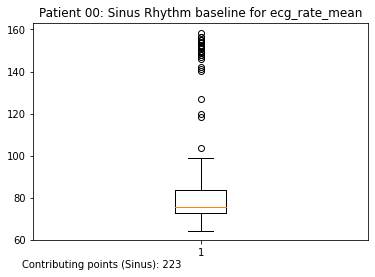

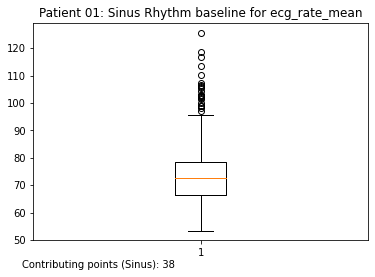

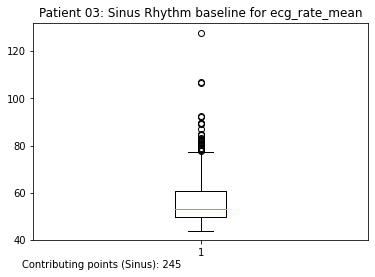

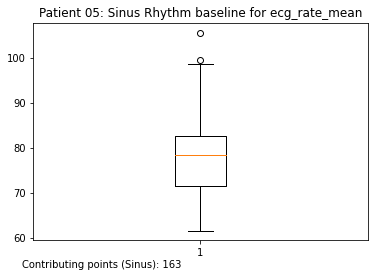

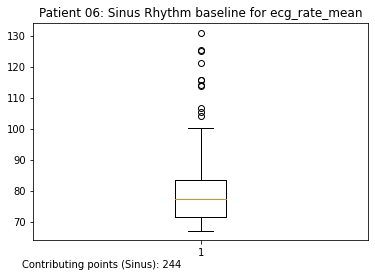

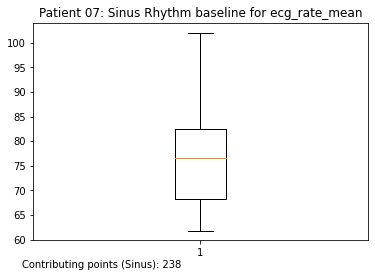

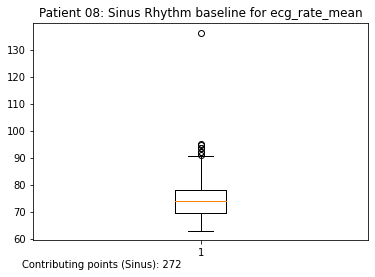

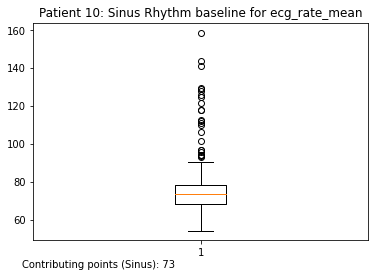

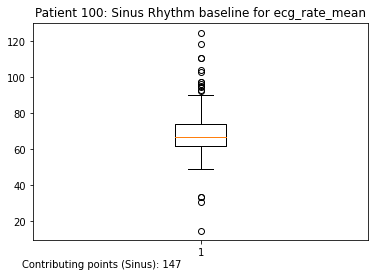

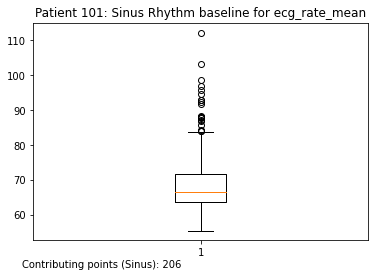

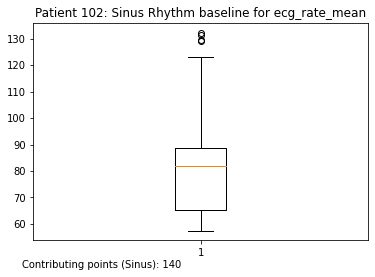

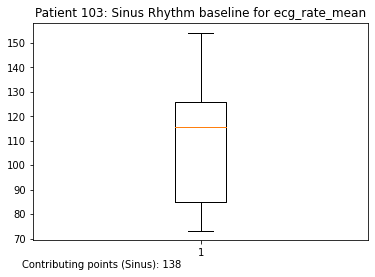

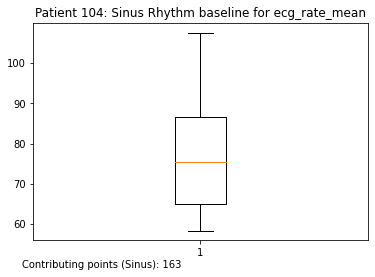

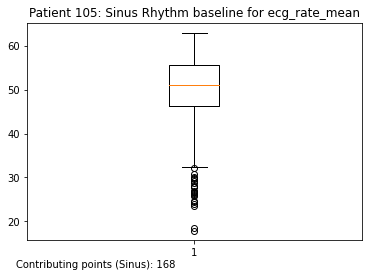

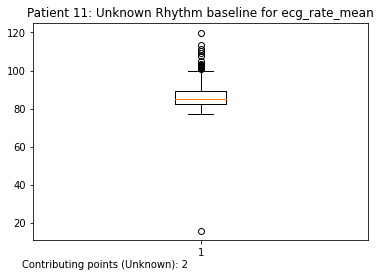

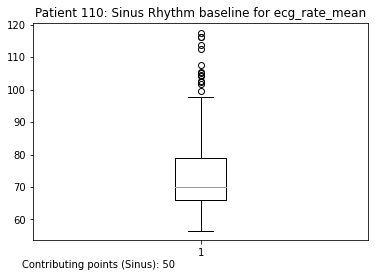

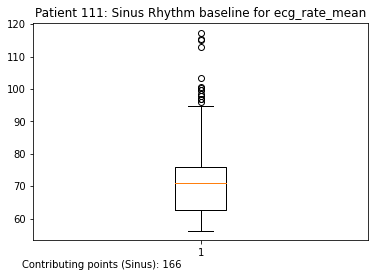

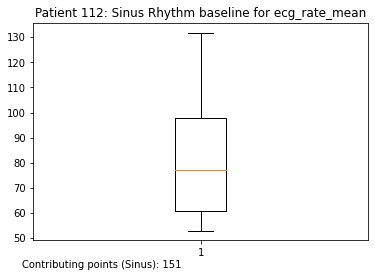

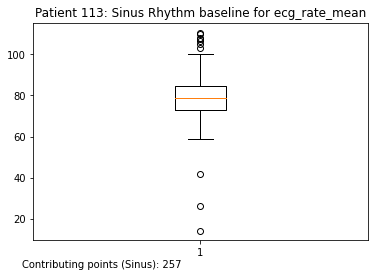

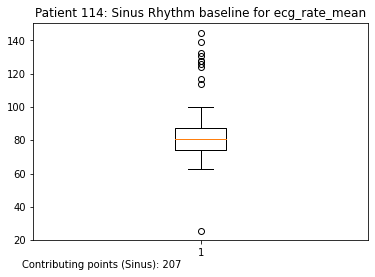

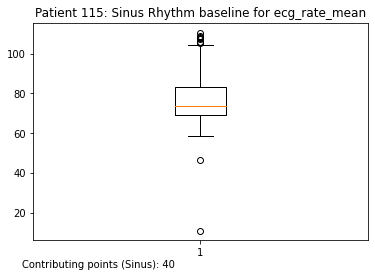

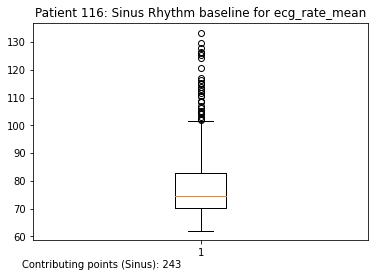

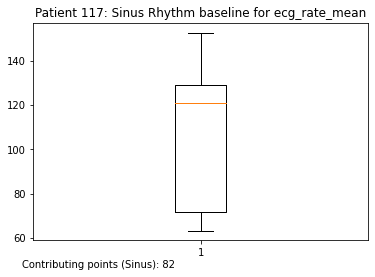

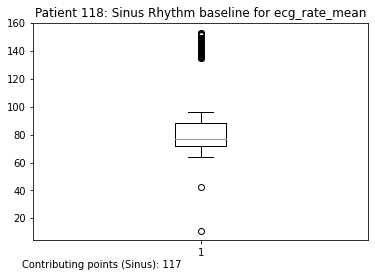

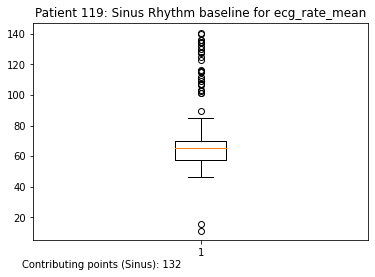

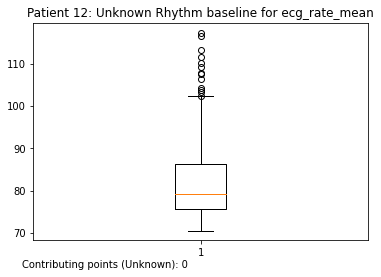

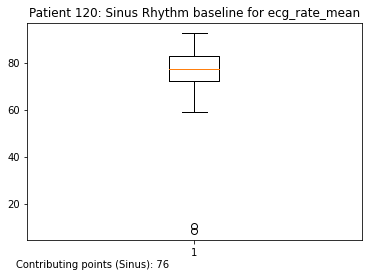

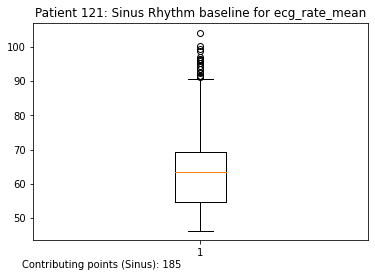

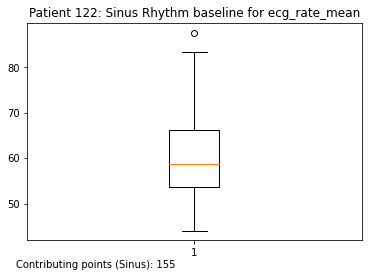

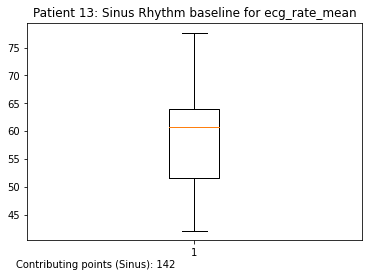

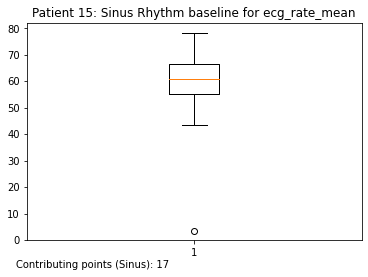

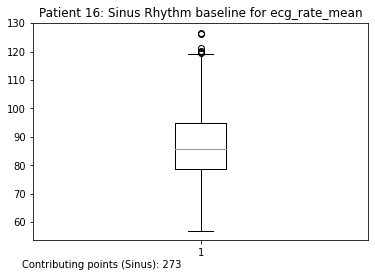

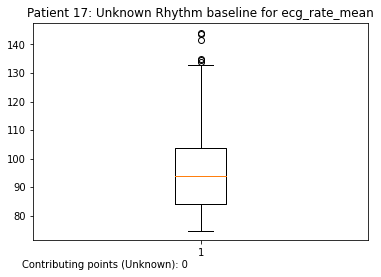

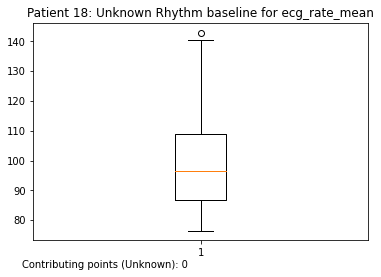

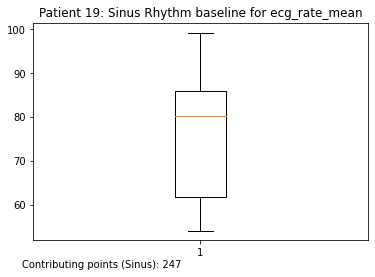

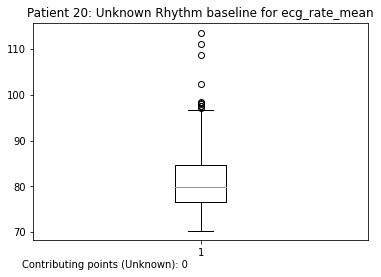

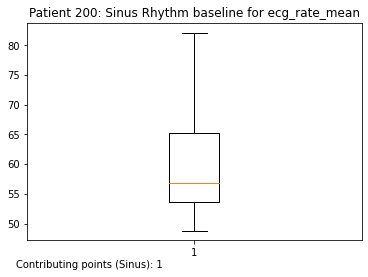

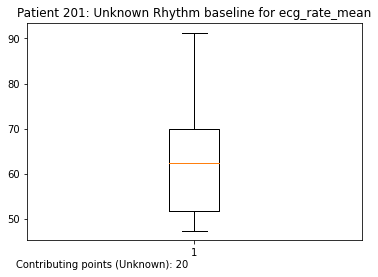

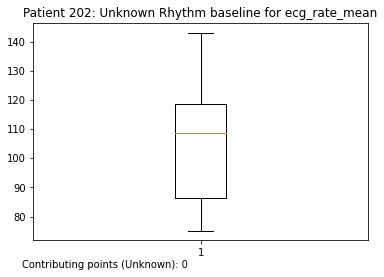

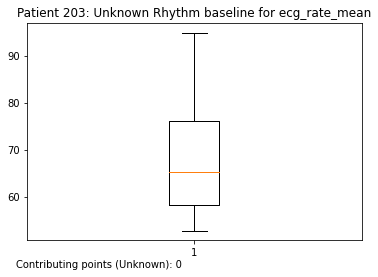

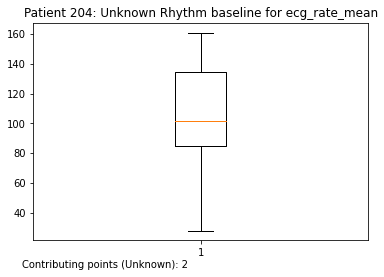

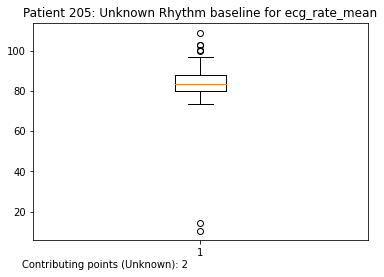

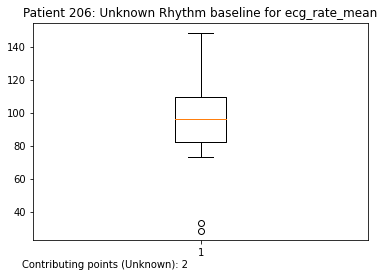

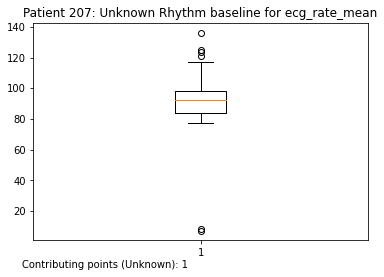

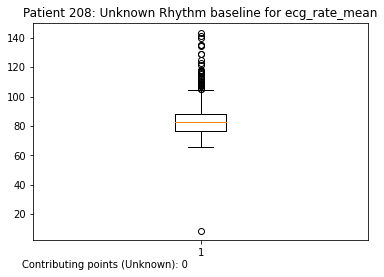

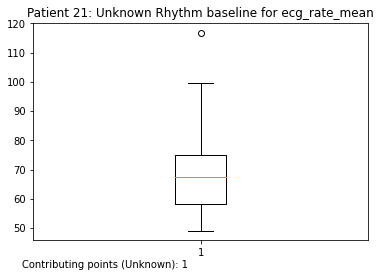

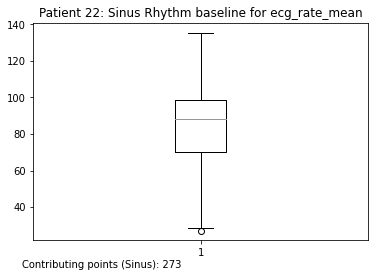

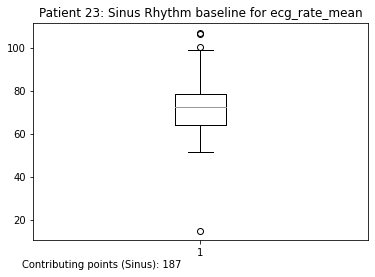

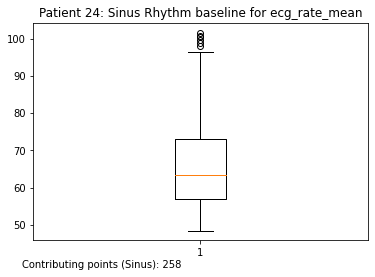

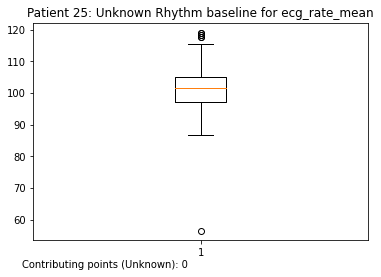

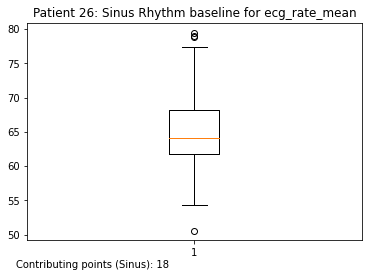

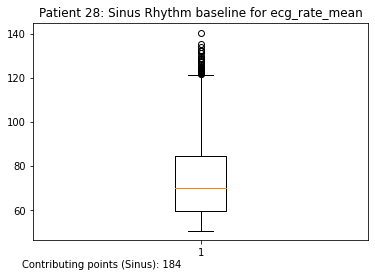

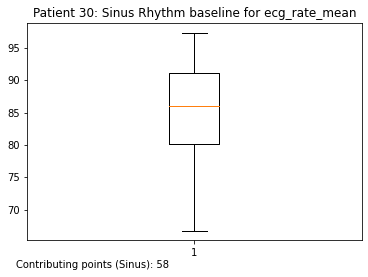

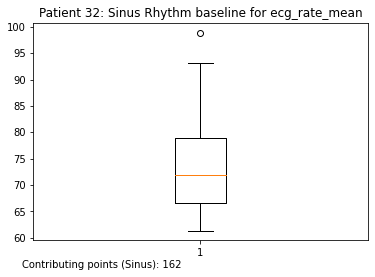

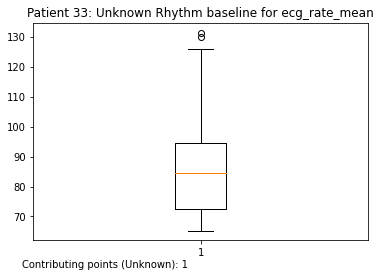

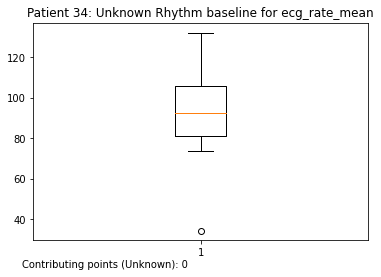

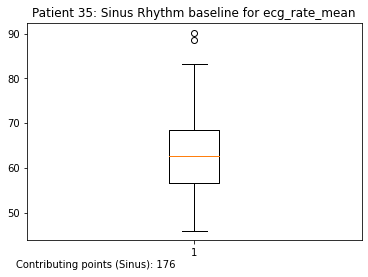

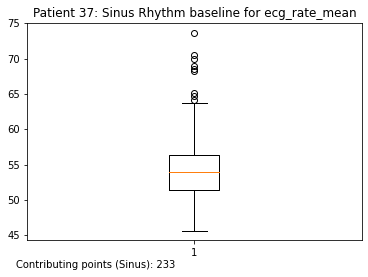

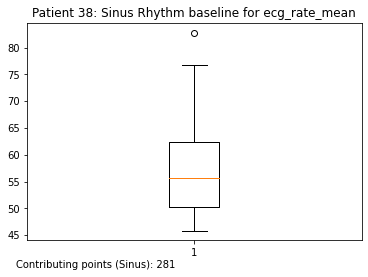

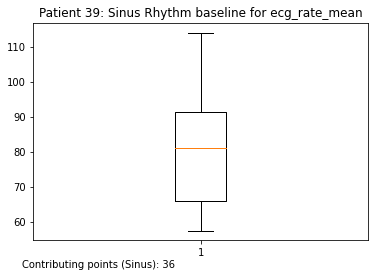

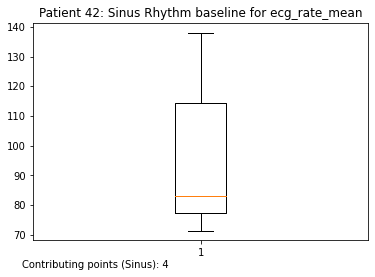

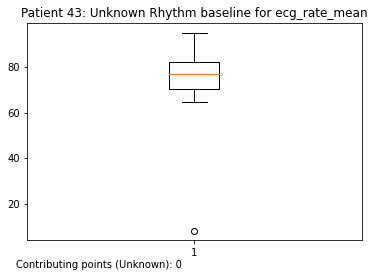

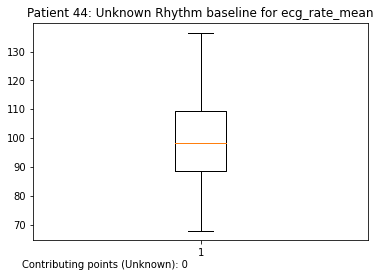

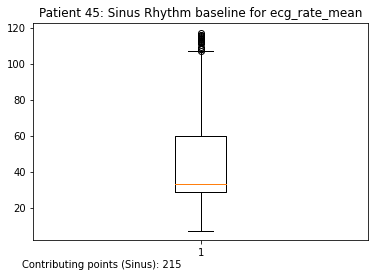

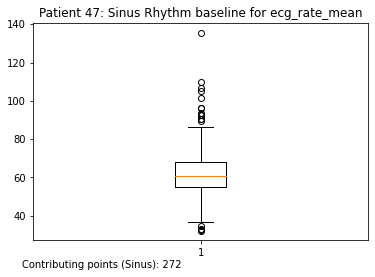

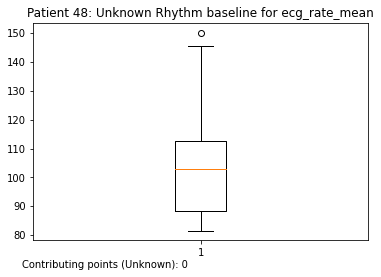

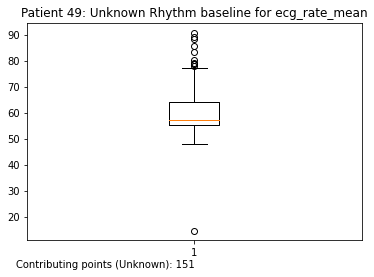

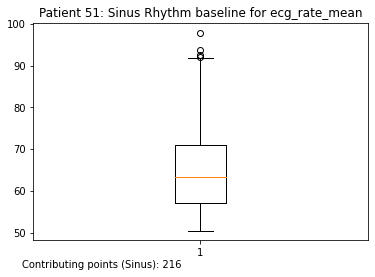

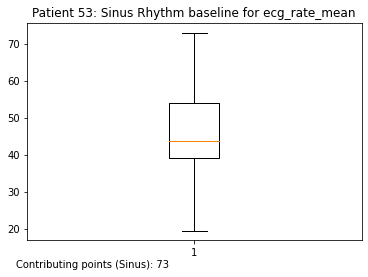

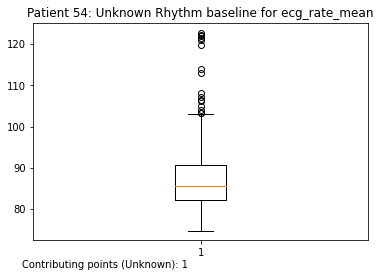

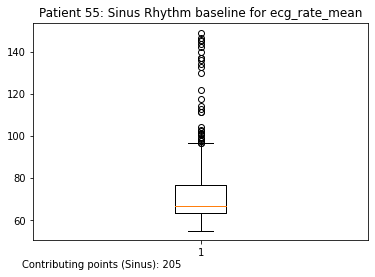

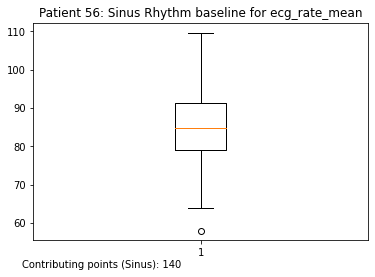

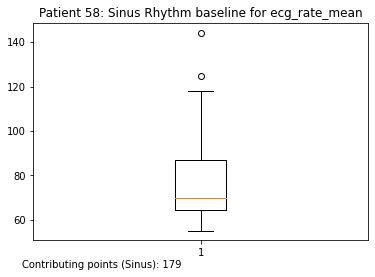

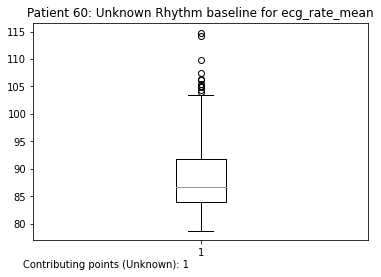

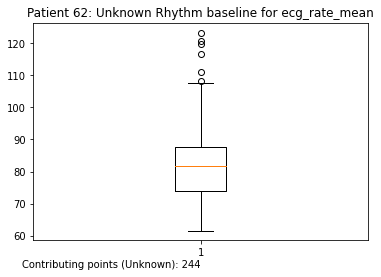

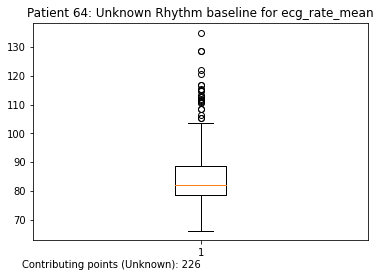

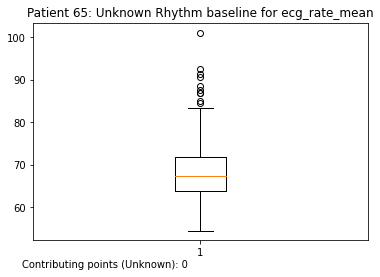

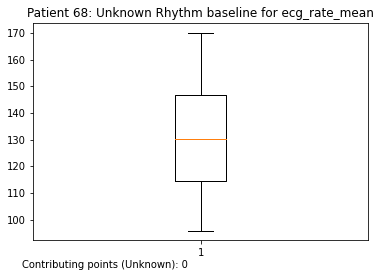

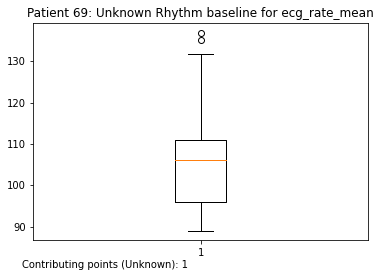

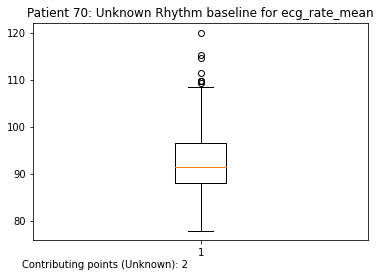

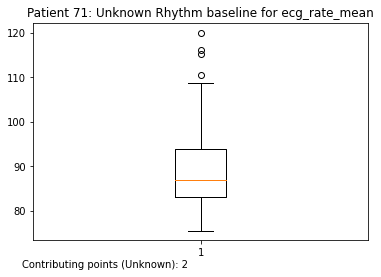

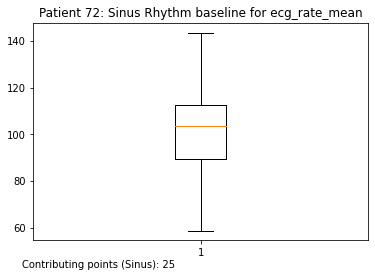

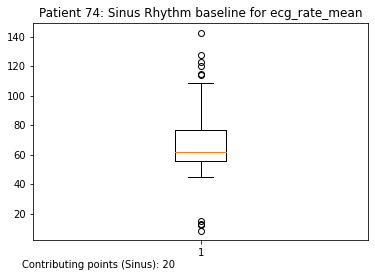

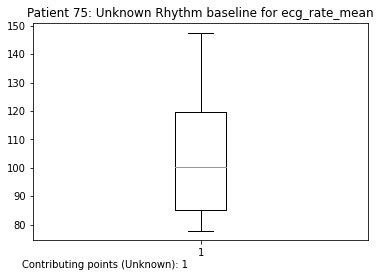

In [3]:
print(len(sinusRhythmBaselines.keys()))
import matplotlib.pyplot as plt
%matplotlib inline
def boxAndWhiskersForSinusRhythmBaselines(df: pd.DataFrame, feature):
    """_summary_

    Args:
        df (pd.DataFrame): including featurized data with additional 'rhythm' column
    """
    missingPatients = set()
    for patient_id, id_group in df.groupby('patient_id'):
        type='Sinus'
        id_groupFiltered = id_group[id_group['rhythm'] == 'sinus']
        if (len(id_groupFiltered) == 0):
            type='Unknown'
            id_groupFiltered = id_group[id_group['rhythm'] == 'unknown']
        if (len(id_groupFiltered) == 0):
            missingPatients.add(patient_id)
        plt.boxplot(id_group[feature])
        plt.title(f'Patient {patient_id}: {type} Rhythm baseline for {feature}')
        plt.figtext(.1, .03, f'Contributing points ({type}): {len(id_groupFiltered)}')
        plt.show()



boxAndWhiskersForSinusRhythmBaselines(dataDF, 'ecg_rate_mean')